<a href="https://colab.research.google.com/github/SeongminCC/PyTorch_project/blob/main/1_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# modules import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

  - 현재 GPU 설정

In [ ]:
torch.cuda.is_available()

True

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
device

device(type='cuda')

# 전처리 설정





In [ ]:
transform = transforms.Compose([transforms.ToTensor(),  # 0~255의 값들을 0~1로 바꿔준다.
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 각 RGB에 대해 평균과 표준편차를 정해 입력한다.
                                transforms.Resize(227)])

# 데이터 로드 및 확인

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='/data',
                                        train=True,
                                        download=True,
                                        transform=transform)

testset = torchvision.datasets.CIFAR10(root='/data',
                                       train=False,
                                       download=True,
                                       transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(trainset,
                          batch_size = 64,
                          shuffle=True,
                          num_workers=2)    # CPU 작업을 몇 개의 코어를 사용해서 진행할지 설정(GPU역시 CPU의 컨트롤을 받기 때문에 설정을 해줘야함)

test_loader = DataLoader(testset,
                         batch_size = 64,
                         shuffle=True,
                         num_workers=2)


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

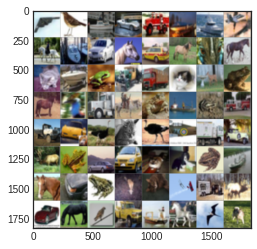

torch.Size([64, 3, 227, 227])


In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # 평균과 표준편차를 전처리 하기 전으로 되돌려준다.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(images.shape)

# 신경망 구성

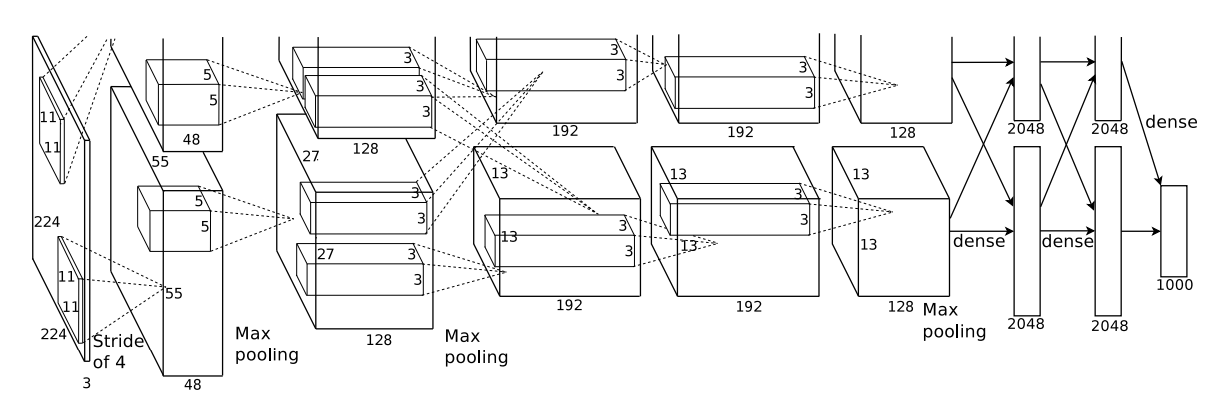

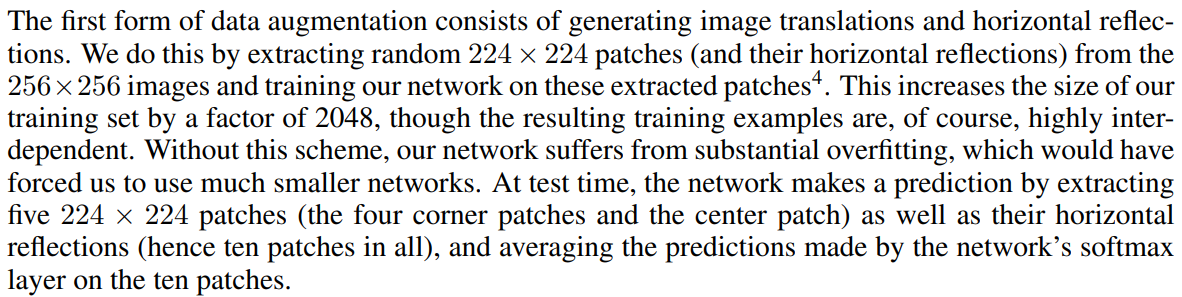

**"Data augmentation"을 위한 첫번 째 방법은**

1. Training
  - 256x256 이미지에서 랜덤으로 224x224 만큼 이미지를 추출 후 이 추출한 patch 들로 훈련
  - training 결과 예제들이 높게 상호의존적임을 확인할 수 있음
  - overfitting 방지
2. Test
  - 본 이미지에서 중앙과 4군데의 모서리 부분, 총 5개의 224x224 크기의 patch들을 추출 후 이 5개의 이미지들을 수평반사 시켜 도합 10개의 patch들을 추출하여 prediction을 구함
  - 구한 prediction값들의 평균값을 구함


In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding = 0)  #( 227 - 11 / 4 ) + 1 = 55
        self.conv2 = nn.Conv2d(96, 256, 5, 1, padding = 2)
        self.conv3 = nn.Conv2d(256, 384, 3, 1, 1)  
        self.conv4 = nn.Conv2d(384, 384, 3, 1, 1)
        self.conv5 = nn.Conv2d(384, 256, 3, 1, 1)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size = 3, stride = 2)
        x = F.local_response_norm(x, size=5, alpha=0.0001, beta=0.75, k=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 3, 2)
        x = F.local_response_norm(x, 5, 0.0001, 0.75, 2)   # 현재는 batch_normalization 기법이 많이 쓰인다.
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, 3, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p = 0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p = 0.5)
        x = self.fc3(x)   # loss인 CrossEntropyLoss에서 softmax를 포함하므로 따로 softmax를 위한 층은 생략한다.
        return x

net = AlexNet().to(device)
print(net)

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
)


# 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
file_name = 'alexnet_cifar10.pth'

In [ ]:
def train(epoch):
  print('\n[ Train epoch: %d ]' % epoch)
  net.train()   # 훈련할 때는 train() 함수 사용
  train_loss = 0
  correct = 0
  total = 0

  for batch_idx, (inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)  # cuda 즉 gpu 환경으로 변경
    optimizer.zero_grad()  # 항상 역전파를 하기 전에 미분값을 0으로 만들어야 한다.

    outputs = net(inputs)
    loss = criterion(outputs, labels)  # 신경망을 나온 결과와 라벨로 손실함수 값을 구한다.
    loss.backward()

    optimizer.step()  # 파라미터를 업데이트 한다.
    train_loss += loss.item()
    _, predicted = outputs.max(1)

    total += labels.size(0)  # 라벨의 크기, 즉 학습한 데이터의 개수를 total에 반복적으로 더한다.(현재는 배치가 64이므로 64개씩 total에 더해진다.)
    current_correct = (predicted == labels).sum().item()    # tensor변수에서 값만 출력하기 위해 item() 함수 사용
    correct += current_correct

    if batch_idx % 100 == 0:   # 배치수가 100개가 될 때마다 현재까지 배치 수 / 정확도 / 손실함수 를 출력
      print('\nCurrent batch:', str(batch_idx))
      print('Current batch average train accuracy:', current_correct / labels.size(0))
      print('Current batch average train loss:', loss.item() / labels.size(0))

  # 훈련이 모두 끝난 후 정확도 / 솔실함수 값을 출력  
  print('\nTotal average train accuarcy:', correct / total)
  print('Total average train loss:', train_loss / total)

def test(epoch):
  print('\n[ Test epoch: %d ]' % epoch)
  net.eval()  # 테스트 할 때는, eval() 함수 사용
  loss = 0
  correct = 0
  total = 0

  for batch_idx, (inputs, labels) in enumerate(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    total += labels.size(0)

    outputs = net(inputs)
    loss += criterion(outputs, labels).item()

    _, predicted = outputs.max(1)
    correct += (predicted == labels).sum().item()

  print('\nTotal average test accuarcy:', correct / total)
  print('Total average test loss:', loss / total)

  state = {
      'net' : net.state_dict()
  }

  if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
  torch.save(state, './checkpoint/' + file_name)
  print('Model Saved!')

**파이토치에서 모델을 저장하고 불러오기 위한 2가지 방법**
  - state_dict 를 저장하고 불러오는 것
    - 학습된 모델의 파라미터만을 저장하기에 모델을 불러올 때 유연함을 살릴 수 있다.
  - 전체 모델을 저장하는 것
    - 직관적인 문법을 사용하며 코드의 양도 적다.
    - 단점 : 직렬화(serialized)된 데이터가 모델을 저장할 때 사용한 특정 클래스 및 디렉토리 구조에 종속(bind)됨 (why? : pickle이 모델 클래스 자체를 저장하지 않기 때문)

        불러올 때 사용되는 클래스가 포함된 파일의 경로를 저장한다. -> 작성한 코드가 다른 프로젝트에서 사용되거나 리팩토링을 거치는 등의 과정에서 동작하지 않을 수 있다.

링크 : https://tutorials.pytorch.kr/recipes/recipes/saving_and_loading_models_for_inference.html

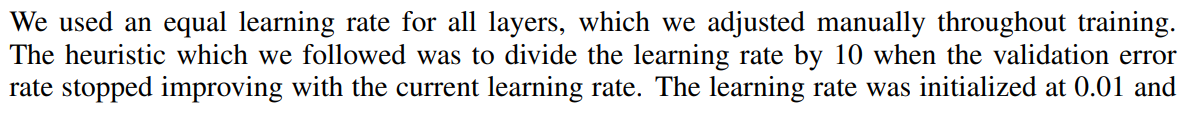

**Alexnet이 lr을 조절하기 위해 사용한 방법은 정확도 즉 손실함수값이 떨어지지 않을 때마다 10씩 나누는 것이다.**

하지만 이 방법을 수동으로 조절하였다고 하였으므로 이번 실험에서는 0.001로 고정하였음



In [ ]:
import time
import os

start_time = time.time()

for epoch in range(0, 10):
  train(epoch)
  test(epoch)
  print('\nTime elapsed:', time.time() - start_time)


[ Train epoch: 0 ]

Current batch: 0
Current batch average train accuracy: 0.125
Current batch average train loss: 0.035950273275375366

Current batch: 100
Current batch average train accuracy: 0.09375
Current batch average train loss: 0.03598230332136154

Current batch: 200
Current batch average train accuracy: 0.09375
Current batch average train loss: 0.03599239140748978

Current batch: 300
Current batch average train accuracy: 0.09375
Current batch average train loss: 0.03596728295087814

Current batch: 400
Current batch average train accuracy: 0.09375
Current batch average train loss: 0.0359480194747448

Current batch: 500
Current batch average train accuracy: 0.09375
Current batch average train loss: 0.035974111407995224

Current batch: 600
Current batch average train accuracy: 0.1875
Current batch average train loss: 0.03596216067671776

Current batch: 700
Current batch average train accuracy: 0.078125
Current batch average train loss: 0.03599667176604271

Total average train ac

**Test Accuracy : 47.95%**

**Test Loss : 0.0221**

**걸린 시간 : 약 21분**